In [1]:
# the classics
import pandas as pd
import numpy as np
import os 
from scipy import stats
from scipy.optimize import curve_fit

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from matplotlib_scalebar.scalebar import ScaleBar
# plot params
plt.rcParams.update({'font.size': 14})
# symbol and color dictionaries for rivers (R), springs (SP), ponded wetland (P), 
# piezometer wetland (PZ), soil gas (SO)
symdict = dict({'R':'o','SP':'s','P':'^','PZ':'v','SO':'P'})
colordict = dict({'R':'mediumblue','SP':'darkorchid','P':'coral','PZ':'deeppink','SO':'yellowgreen'}) 

# mapping stuff 
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import earthpy.spatial as es
from shapely.geometry import Polygon
from shapely.geometry.point import Point

In [2]:
## read in the dataset that has pyCO2sys calculations
df = pd.read_csv('data/watersamples_carbcalc.csv',parse_dates=['datetime'],na_values=['nan','NAN','ibid'],index_col=0)
soil = pd.read_csv('data/soil_gas.csv')

# read in the GRASS GIS model
net = pd.read_csv('map/network.csv',index_col=0)
net['stream'] = net['value'] # not sure why, but the "value" column output from grass is correct and "stream" was not
net['elev_m']= net['elev_ft']*0.3048 # convert ft to m!

netall = net.copy() # copy the dataframe so we can match sites to the network

# match sites to network 
for i in df.index:
    if df.loc[i,'sample_type'] != 'R':
        continue

    templat = df.loc[i,'latitude']
    templong = df.loc[i,'longitude']
    
    tempdist = np.sqrt((netall['latitude']-templat)**2+(netall['longitude']-templong)**2)

    netall.loc[tempdist==np.min(tempdist),'sample_name'] = df.loc[i,'sample_name']
    
    tempdist = np.sqrt((net['latitude']-templat)**2+(net['longitude']-templong)**2)

    net.loc[tempdist==np.min(tempdist),'sample_name'] = df.loc[i,'sample_name']

# merge netall data to dataframe of samples
df_merged = df.merge(netall.drop(['latitude','longitude'],axis=1),on=['sample_name'],how='left')

## site 7 definitely had squishy riparian area. mapped wetland is more than 10m away though
df_merged.loc[df_merged['sample_name']=='ER23-7','wetland']=1

# export to final dataset "df_merged.csv"
df_merged.to_csv('data/watersamples_merged.csv')
        
# copy sample names to the network dataframe
## net doesnt get exported until later, after we put the "clip" column in
net = net.merge(df.drop(['latitude','longitude'],axis=1),on=['sample_name'],how='left')

Here, we want to alter the stream network for the "clipped" case. Here, we limit the extent of the stream network to only be within 20m of the uppermost sampled locations. 

I also generate an extra map of where the discharge measurements are located in the stream network. 

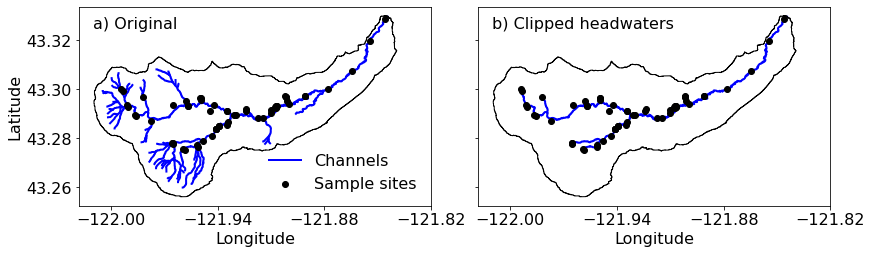

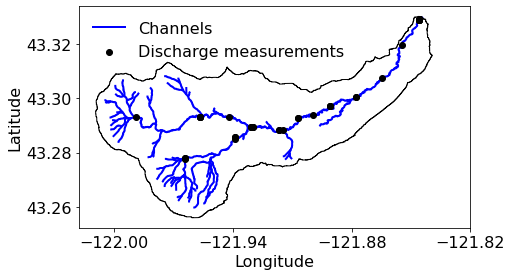

In [17]:
## CLIPPING
plt.rcParams.update({'font.size': 16})

fig,ax=plt.subplots(1,2,figsize=(12,6),sharex=True,sharey=True,constrained_layout=True)
fig2,ax2=plt.subplots(1,1,figsize=(7,6),constrained_layout=True)

net['clip'] = np.nan
net['upstreamwet'] = np.nan

toponums = list(set(net['topo']))

legendbool=True

for i in list(reversed(toponums)):
        
    tempstreamlist = set(net.loc[net['topo']==i,'stream'])
    
    for j in tempstreamlist:  

        temp = net.loc[net['stream']==j,:].sort_values('distance',ascending=False)
        
        streamindex=temp.index
        
        nextstreamindex = net['stream'].isin(set(temp['next_stream']))
        
        # plot unclipped
        if legendbool:
            label=''
            legendbool=False
        else:
            label='_nolegend_'
        
        ax[0].plot(temp['longitude'],temp['latitude'],c='b',zorder=1,lw=2,label=label)
        ax2.plot(temp['longitude'],temp['latitude'],c='b',zorder=1,lw=2,label=label)

        
        if (temp['sample_name'].isna().all() and (temp['clip'].isna().all())): # if no samples and not already set (by upstream observation)
            net.loc[streamindex,'clip'] = 1

        elif (~temp['sample_name'].isna().all() and (temp['clip'].isna().all())):  # if sample but not already set by upstream obs
            
            streamindex_cut = temp.index[np.min(np.where(~temp['sample_name'].isna()))-2:] # cut to 2 cells up (20m)
            
            net.loc[streamindex_cut,'clip']=0
            net.loc[nextstreamindex,'clip']=0
            
            net.loc[streamindex_cut,'clip_strahler1'] = 1
            
            temp = temp.loc[streamindex_cut,:]
            
            ax[1].plot(temp['longitude'],temp['latitude'],c='b',zorder=1,lw=2)
            
        else: # if upstream obs
            net.loc[streamindex,'clip']=0
            net.loc[nextstreamindex,'clip']=0
            net.loc[streamindex,'clip_strahler1'] = 0
 
            ax[1].plot(temp['longitude'],temp['latitude'],c='b',zorder=1,lw=2)
        
        
    
#sample sites
ax[0].scatter(df_merged['longitude'],df_merged['latitude'],c='k')
ax[1].scatter(df_merged['longitude'],df_merged['latitude'],c='k')

## add discharge sampling sites to map 2
dfd = pd.read_csv('data/discharge_corrected52825.csv',parse_dates=['date'])
dfd['site_id'] = dfd['site']
dfdfit = dfd.loc[((dfd['season'].isin(['sp23','sp22','fa22','fa21']))),:]

ax2.scatter(dfdfit['longitude'],dfdfit['latitude'],c='k')
        

# label 
ax[0].text(-122.01,43.325,'a) Original')
ax[1].text(-122.01,43.325,'b) Clipped headwaters')

# add some other vectors
watershed = gpd.read_file('map/watershed_area_vector.shp')

watershed.plot(ax = ax[0], color = 'none', edgecolor = 'k',zorder=2,lw=1)
watershed.plot(ax = ax[1], color = 'none', edgecolor = 'k',zorder=2,lw=1)
watershed.plot(ax = ax2, color = 'none', edgecolor = 'k',zorder=2,lw=1)

# adjust ticks
ax[0].set_xticks(np.linspace(-122.0,-121.82,4))
ax[1].set_xticks(np.linspace(-122.0,-121.82,4))
ax2.set_xticks(np.linspace(-122.0,-121.82,4))

# labels
ax[0].set_xlabel('Longitude')
ax[1].set_xlabel('Longitude')
ax2.set_xlabel('Longitude')

ax[0].set_ylabel('Latitude')
ax2.set_ylabel('Latitude')

# legends
ax[0].legend(['Channels','Sample sites'],loc='lower right',frameon=False)
ax2.legend(['Channels','Discharge measurements'],frameon=False)

# savefigs
fig.savefig('plots/FigS6_map_clipped.pdf')
fig2.savefig('plots/FigS2_map_discharge.pdf')


Now let's make the main map, Figure 1

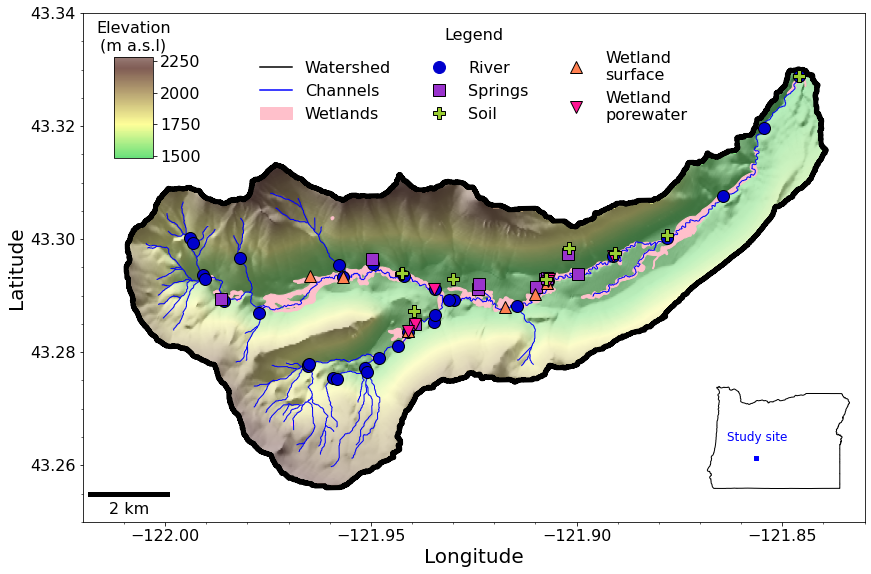

In [4]:
# the main map, Figure 1 
plt.rcParams.update({'font.size': 16})

fig,ax=plt.subplots(figsize=(12,8),layout='constrained')

### some plot params
psize=12

# add river channels first
for i in range(1,6):
    
    temp = net.loc[net['strahler']==i,:]
        
    tempstreamlist = set(temp['stream'])
    
    for j in tempstreamlist:
        temptemp = temp.loc[temp['stream']==j,:].sort_values('distance')
        
        
        ax.plot(temptemp['longitude'],temptemp['latitude'],c='b',zorder=1,lw=1)
    

# import dem
dem= rasterio.open('map/30m_dem_formap.tif')
# import watershed
watershed = gpd.read_file('map/watershed_area_vector.shp')

# mask the dem to the watershed geometry
dem1, dem1_transform=rasterio.mask.mask(dem, watershed.geometry,crop=True)
dem1=np.where(dem1==dem1.min(),np.nan,dem1)

## show DEM
# custom cmap from https://stackoverflow.com/questions/35920887/select-part-of-the-colormap-plotting-terrain
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
    cmap(np.linspace(minval, maxval, n)))
    return new_cmap    

cmap = plt.get_cmap('terrain')
new_cmap = truncate_colormap(cmap, 0.35, 0.8) # truncate to get colors that aren't blue

# plot the dem
demshow = show(dem1,transform=dem1_transform,ax=ax, cmap=new_cmap,zorder=0)


### put in a hillshade
### try earthpy hillshade
hillshade = es.hillshade(dem1[0,:,:],azimuth=150, altitude=15) # this looks good
# plot
hsshow = show(hillshade,transform=dem1_transform,ax=ax,cmap='Greys',alpha=0.5)

# plot watershed
watershed.plot(ax = ax, color = 'none', edgecolor = 'k',zorder=2,lw=5)

# read in wetlands and plot
wetland = gpd.read_file('map/wetlands_buffer.shp')
wetland_clipped = wetland.clip(watershed)
wetland_clipped.plot(ax = ax, color = 'pink', edgecolor = 'pink',zorder=0)

## add scale bar from https://geopandas.org/en/stable/gallery/matplotlib_scalebar.html
### IMPORTANT: dx argument here is "dx should be equal to a distance in meters of two points with the same 
### latitude (Y coordinate) which are one full degree of longitude (X) apart"
points = gpd.GeoSeries(
    [Point(-121, 43.3), Point(-122, 43.3)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)
distance_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(distance_meters,location='lower left'))


# add a colorbar for dem elevation
cbar_axis = inset_axes(ax, width='100%', height='100%',bbox_to_anchor=[0.05,0.73,0.05,0.2],bbox_transform=ax.transAxes)
cbar=fig.colorbar(demshow.get_images()[0], ax=ax,cax=cbar_axis,ticks=[1500,1750,2000,2250])#,ticks=[150000,175000,200000,225000])
cbar.ax.set_yticklabels([1500,1750,2000,2250])
cbar_axis.set_title('Elevation\n(m a.s.l)',fontsize=16)


# # add sample sites
for i,val in enumerate(['R','SP','P','PZ']):
    temp = df_merged.loc[df_merged['sample_type']==val,:]
    ax.plot(temp['longitude'],temp['latitude'],c=colordict[val],marker=symdict[val],markeredgecolor='k',ls='',markersize=psize)

# add soil sample locations    
ax.plot(soil['longitude'],soil['latitude'],c=colordict['SO'],markeredgecolor='k',ls='',markersize=psize,marker=symdict['SO'])

# big legend
legend=[Line2D([0],[0],ls='-',c='k',label='Watershed'),
       Line2D([0],[0],ls='-',c='b',label='Channels'),
       mpatches.Patch(color='pink', label='Wetlands'),
        Line2D([0],[0],ls='',c=colordict['R'],marker='o',label='River',markersize=psize),
       Line2D([0],[0],ls='',c=colordict['SP'],marker=symdict['SP'],label='Springs',markeredgecolor='k',markersize=psize),
        Line2D([0],[0],ls='',marker=symdict['SO'],c=colordict['SO'],label='Soil',markeredgecolor='k',markersize=psize),
    Line2D([0],[0],ls='',c=colordict['P'],marker=symdict['P'],label='Wetland\nsurface',markeredgecolor='k',markersize=psize),

       Line2D([0],[0],ls='',c=colordict['PZ'],marker=symdict['PZ'],label='Wetland\nporewater',markeredgecolor='k',markersize=psize)]

ax.legend(handles=legend,loc='upper center',frameon=False,ncol=3,title='Legend')


### finally, add a little Oregon
states = gpd.read_file('map/tl_2023_us_state.shp')
oregon = states.loc[states['NAME']=='Oregon'].to_crs(watershed.crs)

# make an inset
ax2 = inset_axes(ax, "20%", "30%", loc="lower right")
# put the little Oregon into the inset
oregon.plot(ax=ax2,color='none',edgecolor='k')
ax2.axis('off')

# plot field site boundary in little Oregon
c =  {'NW': [-122.02, 43.37],
      'NE': [-121.81, 43.37],
      'SE': [-121.81, 43.25],
      'SW': [-122.02, 43.25]}

poly1 = Polygon([c['NW'], c['NE'], c['SE'], c['SW']])

polygon = gpd.GeoDataFrame(index=[0], crs=watershed.crs, geometry=[poly1])

polygon.plot(ax=ax2,color='b',lw=24)

ax2.scatter(-121.9,43.3,c='b',marker='s',s=10)

ax2.annotate(xy=(-121.9,43.3),xytext=(-121.80,44),text='Study site',c='b',fontsize=12,horizontalalignment='center')#,arrowprops=dict(arrowstyle= '->',color='b'))


## set the axis lims
ax.set_xlim([-122.02,-121.83])
ax.set_ylim([43.25,43.34])

# adjust ticks and tick labels
ax.set_xticks([-122,-121.95,-121.90,-121.85])
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# axis labels
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)


fig.savefig('plots/Fig1_map.pdf',bbox_inches = 'tight')

In [5]:
# make network logic dict: get what is upstream of a given stream segment
upstreamnetwork=pd.DataFrame(index=list(set(net['stream'])),columns=['down'])
for s in set(net['stream']):
    upstream=net.loc[net['next_stream']==s,'stream'].values
    upstreamvalue = upstream[upstream!=s]
    
    for si in set(upstreamvalue):
        upstreamnetwork.loc[si,'down']=s
        
upstreamnetwork.to_csv('map/network_upstream.csv')

In [18]:
# do geometry scaling here, too
plt.rcParams.update({'font.size': 18})

# geometry scaling
dfd = pd.read_csv('data/discharge.csv',parse_dates=['date'])


dfd['site_id'] = dfd['site']

df = pd.read_csv('data/watersamples_merged.csv',parse_dates=['datetime'],na_values=['nan','NAN','ibid'])
df_tomerge = df.loc[df['sample_name'].isin(['ER23-2','ER23-75 Jun12','ER23-23']),:] # only these sites we measured Q in sp23

# get just the Spring 2023 data (the sampling period that we use for this paper)
sp23 = dfd.loc[dfd['season']=='sp23',:]
sp23.rename(columns={'site':'site_id'})
sp23merge = sp23.merge(df_tomerge[['site_id','latitude','longitude','area_10m2']],on='site_id',how='left')

# from SP23, specific discharge calculation: discharge over upstream area
specd = (3600*365*24)*sp23merge['discharge_m3_s']/(sp23merge['area_10m2']*100) # area is in number of pixels 10 m^2 -> convert to m^2

print('For 5 discharge measurements across 3 sites:')
print(f'mean specific discharge is {round(np.nanmean(specd),2)} m/yr')
print(f'CV of specific discharge is {round(100*np.nanstd(specd)/np.nanmean(specd),1)}%')

# for easy conversion, units dont have to be m/yr -> just want Q in m^3/s from area in km^2
specd_out = np.nanmean(sp23merge['discharge_m3_s']/(sp23merge['area_10m2'])) # this is in m^3 /s / km^2

# make dataframe output
df_out = pd.Series(index=['specd','va','vb','wa','wb','da','db'])
df_out['specd'] = specd_out

For 5 discharge measurements across 3 sites:
mean specific discharge is 1.69 m/yr
CV of specific discharge is 11.8%


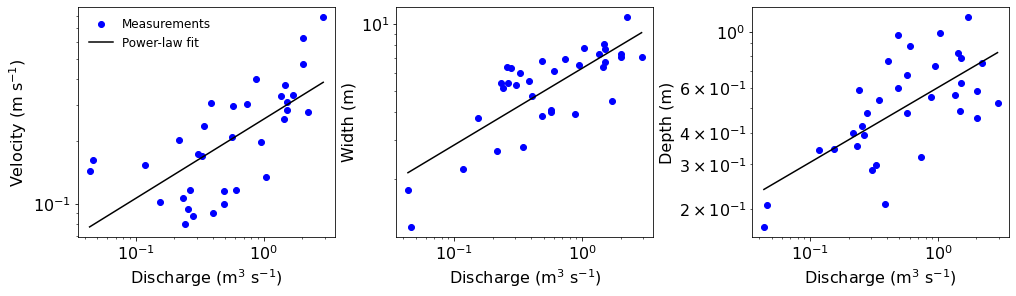

In [19]:
plt.rcParams.update({'font.size': 16})

fig,ax=plt.subplots(1,3,figsize=(14,4),constrained_layout=True)
ax = ax.flatten()

dfdfit = dfd.loc[((dfd['season'].isin(['sp23','sp22','fa22','fa21']))),:]

# exclude site 79 and 80 because they were "quick and dirty" measurements of very shallow water: 1 velocity measurmeent only
# the other Q data are long cross-sections with multiple velocity and depth measurements
# ER21-27 had only 4 measurements, but one accounted for more than 50% of the flow. so exclude that one too
dfdfit.loc[dfdfit['site'].isin(['79','80','27']),'discharge_m3_s'] = np.nan

ax[0].scatter(dfdfit['discharge_m3_s'],dfdfit['velocity_m_s'],c='blue')
ax[1].scatter(dfdfit['discharge_m3_s'],dfdfit['width_m'],c='blue')
ax[2].scatter(dfdfit['discharge_m3_s'],dfdfit['depth_m'],c='blue')

[ax[i].set_xscale('log') for i in range(0,3)]
[ax[i].set_yscale('log') for i in range(0,3)]

xfit = dfdfit['discharge_m3_s']
yfit1 = dfdfit['velocity_m_s']
yfit2 = dfdfit['width_m']
yfit3 = dfdfit['depth_m']

nanmask1 = np.isnan(xfit) | np.isnan(yfit1) 
nanmask2 = np.isnan(xfit) | np.isnan(yfit2) 
nanmask3 = np.isnan(xfit) | np.isnan(yfit3) 

# fit powerlaw functions
res1 = stats.linregress(np.log(xfit[~nanmask1]),np.log(yfit1[~nanmask1]))
res2 = stats.linregress(np.log(xfit[~nanmask2]),np.log(yfit2[~nanmask2]))
res3 = stats.linregress(np.log(xfit[~nanmask3]),np.log(yfit3[~nanmask3]))
plotx = np.linspace(np.min(dfdfit['discharge_m3_s']),np.max(dfdfit['discharge_m3_s']),100)

ax[0].plot(plotx,np.exp(np.log(plotx)*res1.slope+res1.intercept),c='k')
ax[1].plot(plotx,np.exp(np.log(plotx)*res2.slope+res2.intercept),c='k')
ax[2].plot(plotx,np.exp(np.log(plotx)*res3.slope+res3.intercept),c='k')

df_out['va'] = res1.intercept
df_out['vb'] = res1.slope
df_out['wa'] = res2.intercept
df_out['wb'] = res2.slope
df_out['da'] = res3.intercept
df_out['db'] = res3.slope

# to express the linear regression of two log-transformed variables as power law, 
# take exp of intercept to get coefficient
df_out_power = df_out.copy()
df_out_power['va'] = np.exp(res1.intercept)
df_out_power['vb'] = res1.slope
df_out_power['wa'] = np.exp(res2.intercept)
df_out_power['wb'] = res2.slope
df_out_power['da'] = np.exp(res3.intercept)
df_out_power['db'] = res3.slope

# labels
ax[0].set_xlabel('Discharge (m$^{3}$ s$^{-1}$)')
ax[0].set_ylabel('Velocity (m s$^{-1}$)')
ax[1].set_xlabel('Discharge (m$^{3}$ s$^{-1}$)')
ax[1].set_ylabel('Width (m)')
ax[2].set_xlabel('Discharge (m$^{3}$ s$^{-1}$)')
ax[2].set_ylabel('Depth (m)')

ax[0].legend(['Measurements','Power-law fit'],frameon=False,fontsize=12)

fig.savefig('plots/FigS5_geometry_scaling.pdf')

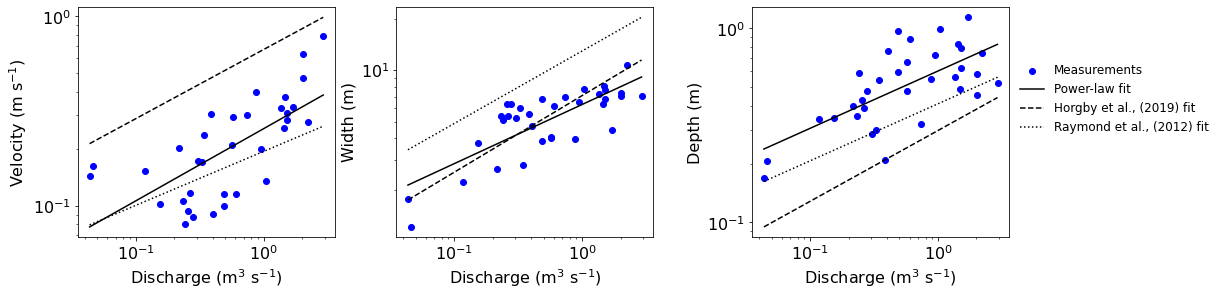

In [20]:
# there's definitely some scatter here. some other studies typically dont measure these directly,
# instead adopting scaling functions for streams in the Swiss mountains, Horgby et al., (2019)
# or from a global compilation, Raymond et al., (2012). 

# Compare our results with predictions
def horgbyv(q):
    return np.exp(0.365*np.log(q)-0.403)

def horgbyw(q):
    return np.exp(0.447*np.log(q)+1.961)

def horgbyz(q):
    return np.exp(0.365*np.log(q)-1.212)

def raymondv(q):
    return np.exp(0.285*np.log(q)-1.64)

def raymondz(q):
    return np.exp(0.294*np.log(q)-0.895)

def raymondw(q):
    return np.exp(0.423*np.log(q)+2.56)

ax[0].plot(plotx,horgbyv(plotx),c='k',ls='--')
ax[1].plot(plotx,horgbyw(plotx),c='k',ls='--')
ax[2].plot(plotx,horgbyz(plotx),c='k',ls='--')

ax[0].plot(plotx,raymondv(plotx),c='k',ls=':')
ax[1].plot(plotx,raymondw(plotx),c='k',ls=':')
ax[2].plot(plotx,raymondz(plotx),c='k',ls=':')

ax[0].get_legend().remove()
ax[2].legend(['Measurements','Power-law fit','Horgby et al., (2019) fit','Raymond et al., (2012) fit'],frameon=False,fontsize=12,bbox_to_anchor=[1,0.8])

fig.savefig('plots/FigS5_geometry_scaling_comparison.pdf')

fig

In [9]:
# despite the scatter, power law fits from our measurements seem adequate
# another way to QA/QC:
print('Check that power law variables are self-consistent')
print('According to Leopold and Maddock 1953, the power-law exponents (b) should sum to 1:')
print(f'sum of exponents: {round(df_out_power["vb"]+df_out_power["wb"]+df_out_power["db"],2)}')
print('According to Leopold and Maddock 1953, the power-law coefficients (a) should multiply together to equal 1:')
print(f'product of coefficients: {round(df_out_power["va"] *df_out_power["wa"] *df_out_power["da"] ,2)}')

# export
df_out.to_csv('data/discharge_scaling.csv')

Check that power law variables are self-consistent
According to Leopold and Maddock 1953, the power-law exponents (b) should sum to 1:
sum of exponents: 1.02
According to Leopold and Maddock 1953, the power-law coefficients (a) should multiply together to equal 1:
product of coefficients: 0.97


In [10]:
# this goes to the paper as power law form
df_out_power

specd    0.000005
va       0.255597
vb       0.380990
wa       6.308249
wb       0.345128
da       0.602728
db       0.295399
dtype: float64

(-0.5, 3.5)

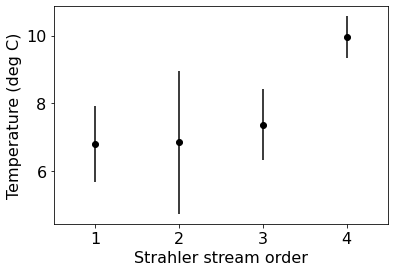

In [11]:
## need to see if temperature varies vs. strahler and if so, add variable temperature across the network model
fig,ax=plt.subplots(1,1)

for s in range(1,5):
    temp = net.loc[net['strahler']==s,:]
    
    plt.errorbar(str(s),np.nanmean(temp['temperature_deg_C']),yerr=np.nanstd(temp['temperature_deg_C']),marker='o',ls='',c='k')
    
    net.loc[net['strahler']==s,'temperature_filled'] = np.nanmean(temp['temperature_deg_C'])
    
plt.ylabel('Temperature (deg C)')
plt.xlabel('Strahler stream order')

mintemp = np.min(net['temperature_filled']) # save min temp for later

plt.xlim([-0.5,3.5])


In [12]:
### prep for full model:
# read in merged network dataframe
# net = pd.read_csv('map/network_merged.csv',index_col=0)

# read in geometry scaling paramters
geometry = pd.read_csv('data/discharge_scaling.csv',index_col=0).iloc[:,0]

def powerlaw(q,a,b):
    return np.exp(b*np.log(q)+a)

# calculate stream discharge, other scaling 
net['discharge'] = net['area_10m2']*geometry.specd
net['velocity'] = powerlaw(net['discharge'],geometry.va,geometry.vb)
net['width'] = powerlaw(net['discharge'],geometry.wa,geometry.wb)
net['depth'] = (net['discharge']/net['velocity'])/net['width']
net['xarea'] =net['width']*net['depth']


net_sorted = pd.DataFrame()
segmentlist = set(net['stream'])
for s in segmentlist:
    tempnet_sorted = net.loc[net['stream']==s,:]
    tempnet_sorted = tempnet_sorted.sort_values('area_10m2') ### VERY IMPORTANT to sort by area 
    
    backwardslope = tempnet_sorted['elev_m']-tempnet_sorted['elev_m'].shift(1) # back
    forwardslope = tempnet_sorted['elev_m'].shift(-1)-tempnet_sorted['elev_m'] # forth
    halfslope = (backwardslope+forwardslope)/2 # average of the two
    
    # use halfslope, but fillna because the top and bottom of each stream segment still needs a slope
    tempnet_sorted['slope'] = halfslope.fillna(backwardslope.fillna(forwardslope))/10 # ## 10 m spacing in the DEM, elevation in m
        
    net_sorted = pd.concat([net_sorted,tempnet_sorted])
    
net_sorted = net_sorted.reset_index()

print(f'{round(100*len(net_sorted.loc[net_sorted["slope"]==0])/len(net_sorted),4)}% of stream segments have 0 slope :0')
print(f'{round(100*len(net_sorted.loc[net_sorted["slope"]>0])/len(net_sorted),4)}% of stream segments have positive slope :)')

# set zero slope segments to the smallest (or least negative) slope
net_sorted.loc[net_sorted['slope']==0,'slope'] = np.nanmax(net_sorted.loc[net_sorted['slope']<0,'slope']) 

17.2359% of stream segments have 0 slope :0
0.0% of stream segments have positive slope :)


In [13]:
# save
net_sorted.to_csv('map/network_merged.csv')

In [14]:
## clipping surface area and length?
delta_x=10
totalarea = np.sum(net['width']*delta_x)
totallength = len(net)

clippedarea = np.sum(net.loc[net['clip']==False,'width']*delta_x)
clippedlength = len(net.loc[net['clip']==False,'width'])

1-clippedarea/totalarea
1-clippedlength/totallength

print(f'Clipping the headwaters reduced total surface area by {round(100*(1-clippedarea/totalarea),1)}%')
print(f'Clipping the headwaters reduced total network length by {round(100*(1-clippedlength/totallength),1)}%')

Clipping the headwaters reduced total surface area by 25.0%
Clipping the headwaters reduced total network length by 56.4%


In [15]:
# wetland area out of total area?
wetland_proj = wetland.to_crs(3857)
watershed_proj = watershed.to_crs(3857)
print(f'Wetlands occupy {100*round(np.sum(wetland_proj["geometry"].area)/np.sum(watershed_proj["geometry"].area),4)}% of the watershed area')

Wetlands occupy 5.45% of the watershed area


In [16]:
# compare cell travel time to radon decay
# 10 m cell length
meanvelocity = np.mean(net['velocity'])
celltraveltime_s = 10/meanvelocity
celltraveltime_d= celltraveltime_s/(3600*24)
radonhalflife = 3.8
cellradondecay = 0.5**(celltraveltime_d/radonhalflife)

print(f'Using average flow velocity from the network model, {round(meanvelocity,2)} m/s')
print(f'It takes about {round(celltraveltime_s,4)} seconds to cross the 10 m of a grid cell')
print(f'During this amount of time, Rn activity is reduced by {round(100*(1-cellradondecay),5)}%')


Using average flow velocity from the network model, 0.13 m/s
It takes about 75.1132 seconds to cross the 10 m of a grid cell
During this amount of time, Rn activity is reduced by 0.01586%


### References

Horgby, Å., Segatto, P. L., Bertuzzo, E., Lauerwald, R., Lehner, B., Ulseth, A. J., ... & Battin, T. J. (2019). Unexpected large evasion fluxes of carbon dioxide from turbulent streams draining the world’s mountains. Nature communications, 10(1), 4888.

Raymond, Peter A., et al. "Scaling the gas transfer velocity and hydraulic geometry in streams and small rivers." Limnology and Oceanography: Fluids and Environments 2.1 (2012): 41-53.

Leopold, L. B., & Maddock, T. (1953). The hydraulic geometry of stream channels and some physiographic implications (Vol. 252). US Government Printing Office.